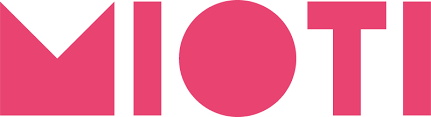
<center style="color:#888">Módulo Advanced Data Science<br/>Natural Language Processing</center>

# S3. Challenge. Clasificación multi-etiqueta (Parte 2)

En este **challenge** vamos a aprender a predecir etiquetas de *posts* de [StackOverflow](https://stackoverflow.com). Técnicamente, es una tarea de clasificación multi-etiqueta. Nótese que el lenguaje en el que están escritas las entradas es el **INGLÉS**, con lo que algunos de los pasos serás específicos para dicho idioma.

## Librerías

Haremos uso de las siguientes librerías
- [Numpy](http://www.numpy.org) 
- [Pandas](https://pandas.pydata.org) 
- [scikit-learn](http://scikit-learn.org/stable/index.html)
- [NLTK](http://www.nltk.org) — librería básica para trabajar con texto en Python

aunque si quieres pudes usar spaCy para algunas tareas.

##  Preprocesado

Una de las primeras técnicas que vamos a utilizar para preprocesar textos es la eliminación de las conocidas como **stop words**, es decir, palabras que no aportan mucho significado, pero que son necesarias para que el texto sea legible y siga las normas. Para ello, lo primero es conseguir una lista con las *stop words* del lenguaje requerido.

Una opción para conseguir esta lista de palabras, es usar la librería `nltk`.

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JPAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En el *challenge* tenemos un dataset con títulos de entradas de StackOverflow, debidamente etiquetado (con 100 etiquetas distintas).

In [2]:
from ast import literal_eval
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pprint

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
train, validation = train_test_split(train, test_size = .15, random_state = 0)
test = read_data('data/test.tsv')

In [5]:
train.head()

,title,tags
96598,How to create an array of leaf nodes of an htm...,"[javascript, arrays, dom]"
10007,how to make maven use test resources,"[java, maven]"
15802,How do I get the path where the user installed...,[java]
9114,why are my buttons not showing up?,"[java, swing]"
34247,How to loop an array with strings as indexes i...,"[php, arrays, string, loops]"


Como vemos, la columna *title* contiene los títulos de las entradas, y la columna *tags* una lista con las etiquetas de cada entrada, que puede ser un número arbitrario.

Para seguir los convenios, inicializamos `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`.

In [6]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test, y_test = test['title'].values, test['tags'].values

La principal dificultad de trabajar con lenguaje natural es que no está estructurado. Si cojemos el texto y creamos tokens simplemente separando por los espacios, tendremos *tokens* como '3.5?', 'do.', etc. Para evitar esos problemas, es útil preprocesar el texto.

### **Tarea 1 (Preprocesado):**

Implementa la función `text_tokenizer()` y `text_prepare()` siguiendo las instrucciones.

In [7]:
from string import ascii_lowercase
from __future__ import annotations

def text_tokenizer(text :str) -> list[str]:
    """
    Transforma un texto (str) en una lista de palabras/tokens (list).
    Es importante usar esta función siempre para ser consistentes.
    """
    ## ESCRIBE AQUÍ TU CÓDIGO
    return text.split()
    ##


# cargamos estas variables fuera de la función
# ya que la creación del set de stopwords es costoso y no queremos
# que se repita cada vez que se llame a la función
REPLACE_BY_SPACE = "[/(){}\[\]\|@,;]"
GOOD_CHARS = ascii_lowercase + "".join([str(n) for n in range(10)]) + " #+_"
STOPWORDS = set(stopwords.words("english"))


def text_prepare(text:str) -> str:
    """
    Preprocesa el texto inicial:
    1. eliminando espacios al inicio y final, y convirtiéndolo a minúsculas
    2. cambia los caracteres de REPLACE_BY_SPACE por espacios
    3. elimina los caracteres que no estén en GOOD_CHARS
    4. elimina los tokens que sean STOPWORDS

    text: str
    return: str
    """
    ## ESCRIBE AQUÍ TU CÓDIGO
    text = text.strip().lower()
    for char in REPLACE_BY_SPACE:
        if char in text:
            text = text.replace(char, " ")
    for char in text:
        if char not in GOOD_CHARS:
            text = text.replace(char, "")
    text = " ".join([word for word in text_tokenizer(text) if word not in STOPWORDS])
    return text
    ##

In [8]:
def test_text_prepare():
    examples = ["   SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Respuesta incorrecta para: '%s'" % text_prepare(ex)
    return '¡Tests correctos!'

print(test_text_prepare())

¡Tests correctos!


Ahora preprocesamos los textos de todos los conjuntos:

In [9]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [10]:
X_train[:3]

['create array leaf nodes html dom using javascript',
 'make maven use test resources',
 'get path user installed java application']

### **Tarea 2 (Cuentas de palabras y etiquetas):** 

Cuénta cuantas veces aparece cada token (palabra) y cada etiqueta en el corpus de entrenamiento. Es decir, crea un diccionario con las cuentas totales de palabras y etiquetas.
 
El resultado deben ser dos diccionarios *tags_counts* y *words_counts* del tipo `{'palabra_o_etiqueta': cuentas}`.

In [11]:
######################################
##ESCRIBE AQUÍ TU CÓDIGO
######################################

from collections import Counter
# Diccionario con todas las etiquetas del corpus de entrenamiento con sus cuentas
tags_counts = Counter([tag for y in y_train for tag in y ])
# Diccionario con todas las palabras del corpus de entrenamiento con sus cuentas
words_counts = Counter([word for sentence in X_train for word in sentence.split()])

##

Exploramos las más comunes:

In [12]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print(most_common_tags)
print(most_common_words)

[('c#', 16259), ('javascript', 16219), ('java', 15835)]
[('using', 7000), ('php', 4776), ('java', 4685)]


### Transformando el texto a vectores

Vamos a construir los vectores asociados a cada frase en dos representaciones distintas.


#### Bag of words

Recuerda que para crear la representación de *bag of words*, convertimos cada frase en un vector que cuenta el número de ocurrencias de cada token. Se siguien los pasos:
1. Encuentra los **N** tokens mas comunes del corpus de entrenamiento y se les asigna un índice, este es nuestro **vocabulario**. Creamos un diccionario para convertir de tokens a índices y viceversa.
2. Para cada frase en el corpus, creamos un vector de dimensión **N** y lo inicializamos con ceros.
3. Iteramos sobre los tokens de cada frase, y si el token está en el diccionario, incrementamos en 1 el índice correspondiente del vector.
   
**Tarea 3 (BagOfWords):** 

Contruye la función que transforma un texto en su representación *bag of words*.

Implementa la codificación de *bag of words* en la función `my_bag_of_words()` con un tamaño de diccionario de **N=5000**. Para definir el diccionario, sólo podemos usar el conjunto de entrenamiento, sino tendríamos un *data leaking*.

Primero, contruimos el vocabulario y los diccionarios correspondientes, así como un `set` con las palabras del diccionario.

In [13]:
DICT_SIZE = 5000

## ESCRIBE AQUÍ TU CÓDIGO
INDEX_TO_WORDS = dict(enumerate(map(lambda x: x[0],words_counts.most_common(n=DICT_SIZE))))
WORDS_TO_INDEX = {v:k for k,v in INDEX_TO_WORDS.items()}
##

ALL_WORDS = WORDS_TO_INDEX.keys()
assert len(ALL_WORDS)==DICT_SIZE

In [14]:
def my_bag_of_words(text: str, words_to_index: dict[str, int]) -> np.array:
    """
    text: str
    words_to_index: dict, diccionario con los índices del vocabulario

    return
    result_vector: numpy.array, vector con la representación bag-of-words de `text`
    """
    dict_size = len(words_to_index)
    result_vector = np.zeros(dict_size)

    ## ESCRIBE AQUÍ TU CÓDIGO
    for word in text_tokenizer(text):
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    ##

    return result_vector

In [15]:
def test_my_bag_of_words():
    words_to_index = {"hi": 0, "you": 1, "me": 2, "are": 3}
    examples = ["hi how are you", "hi hi hi you house"]
    answers = [[1, 1, 0, 1], [3, 1, 0, 0]]
    for ex, expected in zip(examples, answers):
        output = my_bag_of_words(ex, words_to_index)
        if (output != np.asarray(expected)).any():
            return f"Respuesta incorrecta: BOW('{ex}') = {output} != {expected}"
    return "¡Tests correctos!"


print(test_my_bag_of_words())

¡Tests correctos!


Ahora aplicamos la función anterior a todos los datos.

La representación *bag of words* devuelve vectores __*sparse*__ (la mayoría de sus entradas son ceros), con lo que conviene usar estructuras de datos especiales para datos *sparse* para ser eficientes.

Hay muchos [tipos de representación sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html), y `sklearn` sólo trabaja con la representación [csr matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), que es la que usamos.

In [16]:
from scipy import sparse as sp_sparse

In [17]:
X_train_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX)) for text in X_train]
)
X_val_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX)) for text in X_val]
)
X_test_mybag = sp_sparse.vstack(
    [sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX)) for text in X_test]
)
print("X_train shape ", X_train_mybag.shape)
print("X_val shape ", X_val_mybag.shape)
print("X_test shape ", X_test_mybag.shape)

X_train shape  (85000, 5000)
X_val shape  (15000, 5000)
X_test shape  (30000, 5000)


#### tf-idf

En vez de hacerlo desde cero, podemos usar la clase [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) de `sklearn`. Como siempre, para entrenar el codificador sólo se puede usar el set de entrenamiento.

Investiga los argumentos que definen `TfidfVectorizer`. Puedes filtrar las palabras muy raras y también las demasiado frecuentes. También permite utilizar combinaciones de palabras como tokens, es decir, n-gramas. Por último, el tokenizador por defecto separa palabras como 'c++' o 'c#' en varios tokens, pero esto no nos interesa, con lo que vamos a indicar que sólo separe por espacios con el parámetro `token_pattern`.

Puedes usar:
* `min_df=5`
* `max_df=0.9`
* `ngram_range=(1,2)` 
* `token_pattern='(\S+)'`

**Tarea 4 (tf-idf):** 

Contruye la función `tfidf_features()` que transforma el corpus en su representación *tf-idf*.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy

# shorthand para el tipado de la CRS sparse matrix
sp_matrix = scipy.sparse.csr.csr_matrix


def tfidf_features(
    X_train: list[str], X_val: list[str], X_test: list[str]
) -> tuple[sp_matrix, sp_matrix, sp_matrix, dict]:
    """
    X_train, X_val, X_test — lista de str
    return representación TF-IDF de train, val y test, y el vocabulario word: idx
    """
    ## ESCRIBE AQUÍ TU CÓDIGO
    
    # Crea el TF-IDF vectorizer con los parámetros adecuados
    tfidf_vectorizer = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern=r'\S+')  # rellena los parámetros
 
    
    
    ## ESCRIBE AQUÍ TU CÓDIGO

    # Ajusta tfidf_vectorizer al set de entrenamiento
    # Transforma los sets de train, test, and val
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    ##

    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

In [19]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [20]:
assert 'c++' in tfidf_vocab.keys()
assert 'c#' in tfidf_vocab.keys()

## Clasificador multi-etiqueta con sklearn

El resultado de nuestro clasificador puede consistir en varias etiquetas. Lo primero que tenemos que hacer, es convertir los `y` en números, al igual que hicimos con las X.

Se puede representar la multi-etiqueta convirtiendo cada lista de clases en un vector de 0's y 1's indicando la presencia de cada una de ellas.

Esto se puede hacer automáticamente con [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) de `sklearn`.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

In [22]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [23]:
#Se visualiza el orden de las palabras etiquetadas
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class',
       'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date',
       'datetime', 'django', 'dom', 'eclipse', 'entity-framework',
       'excel', 'facebook', 'file', 'forms', 'function', 'generics',
       'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel',
       'linq', 'linux', 'list', 'loops', 'maven', 'mongodb',
       'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c',
       'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php',
       'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r',
       'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3',
       'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring',
       'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing',
       'twitter-bootstrap'

In [24]:
print(y_train[0:5])

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 

### **Tarea 5 (Entrenamiento):** 

Implementa la función `train_classifier()` que entrena un clasificador dados los datos de entrenamiento. 

Como ya sabes, una clasificación multi-clase con $L$ etiquetas, se puede estudiar como $L$ clasificadores binarios. Esto se puede hacer en el formato *Uno contra todos*, que está implementado en [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html).

Como clasificador base se puede usar [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Es uno de los métodos más simples, pero generalmente funciona bien en tareas de clasificación de texto.

In [25]:
X_test_tfidf.shape

(30000, 15708)

In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [27]:
def train_classifier(X_train: sp_matrix, y_train: np.array):
    """
    X_train: sparse matrix con los datos X del conjunto de entrenamiento vectorizados
    y_train: matriz con etiquetas binarizas

    return: trained classifier
    """

    # Crea y haz fit de una LogisticRegression envuelta en un OneVsRestClassifier.
    assert X_train.shape[0] == y_train.shape[0]
    ######################################
    ## ESCRIBE AQUÍ TU CÓDIGO
    ######################################
    model = OneVsRestClassifier(LogisticRegression(max_iter=1000)).fit(X_train,y_train)
    return model

Entrena un modelo para cada una de las features que hemos construido: *bag-of-words* y *tf-idf*. Y luego calcula las predicciones sobre el conjunto de validación, vamos a necesitar las predicciones (labels) y las probabilidades (scores) para poder calcular métricas como la ROC curve.

In [28]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [29]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Veamos algún ejemplo:

In [30]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print(
        "Title:\t'{}'\nTrue labels:\t\t{}\nPredicted labels:\t{}\n\n".format(
            X_val[i], ",".join(y_val_inversed[i]), ",".join(y_val_pred_inversed[i])
        )
    )

Title:	'imlementing custom irouter aspnet 5 vnext mvc 6'
True labels:		asp.net-mvc,c#
Predicted labels:	asp.net,c#


Title:	'uiwebview application using proxy server'
True labels:		ios,objective-c
Predicted labels:	


Title:	'formal argument type matched multiple actual arguments'
True labels:		r
Predicted labels:	




### Evaluación

Para evaluar el modelo de clasificación multi-clase, usaremos las siguientes métricas:

 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 

Estudia el significado de cada de las métricas, teniendo en cuenta que estamos ante un problema multi-clase y no binario. Lee sobre micro/macro/weighted averaging en la documentación de `sklearn`.

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

### **Tarea 6 (Evaluación):** 

Implementa la función `print_evaluation_scores()` que calcula e imprime las siguientes métricas:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*
 - *Recall macro/micro/weighted*
 
Utiliza para ello las implementaciones de estas métricas de `sklearn`.

In [32]:
def print_evaluation_scores(y_true, y_pred):
    ######################################
    ### ESCRIBE AQUÍ TU CÓDIGO
    ######################################
    avgs=['macro','micro','weighted']
    print(f'Accuracy = {np.round( accuracy_score(y_true,y_pred),decimals=3)}')
    for avg in avgs:
        print(f'f1({avg}) = {np.round(f1_score(y_true,y_pred,average=avg) , decimals = 3)}')
    for avg in avgs:
        print(f'precision({avg}) = {np.round(average_precision_score(y_true,y_pred,average=avg), decimals = 3)}')
    for avg in avgs:
        print(f'recall({avg}) = {np.round(recall_score(y_true,y_pred,average=avg), decimals = 3)}')
    
    return None

In [33]:
print("Bag-of-words")
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print("\nTfidf")
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy = 0.355
f1(macro) = 0.493
f1(micro) = 0.664
f1(weighted) = 0.643
precision(macro) = 0.332
precision(micro) = 0.472
precision(weighted) = 0.504
recall(macro) = 0.4
recall(micro) = 0.545
recall(weighted) = 0.545

Tfidf
Accuracy = 0.327
f1(macro) = 0.432
f1(micro) = 0.628
f1(weighted) = 0.602
precision(macro) = 0.287
precision(micro) = 0.442
precision(weighted) = 0.472
recall(macro) = 0.326
recall(micro) = 0.486
recall(weighted) = 0.486


Es posible que también construir una generalización de la [curva ROC] (http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) para el caso de clasificación multi-etiqueta. 

Puedes cargar la función `roc_auc()` del módulo `metrics.py` en la misma carpeta del challenge. 

Los parámetros de entrada de esta función son:
 - y_test: Etiquetas verdaderas
 - y_score: Scores (probabilidades) del clasificador
 - n_classes: Número de etiquetas

Número de etiquetas: 100


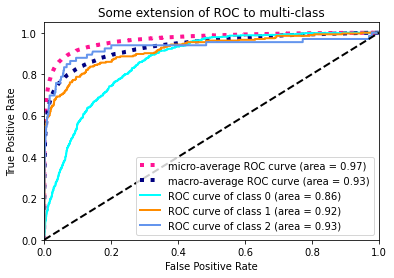

In [34]:
from metrics import roc_auc

n_labels = len(tags_counts)
print(f"Número de etiquetas: {n_labels}")
roc_auc(y_val, y_val_predicted_scores_mybag, n_labels)

### Extra : Hyper parameter tuning

Una vez hemos entrenado un modelo y lo hemos evaluado, podemos proceder a hacer ajuste de hiperparámetros, para ello usaremos como métrica de validación *F1-score weighted*, **sobre los datos de validación**.

Por ejemplo, puedes seguir la siguiente estrategia:
* Compara la calidad de bag of words y TF-IDF y elige uno.
* Investiga cambiando los parámetros de la regularización *L1* y *L2* de la Logistic Regression (e.g. C con valores de 0.1, 1, 10, 100). 

Puedes elegir también otro clasificador base, como Random Forest. O modificar el preprocessing.

Para finalizar, evalua el mejor modelo (sobre la métrica de validación) en el **set de test** para estimar sus métricas.

* Se elige **Bag of words** al haber conseguido unas métricas mejores en el primer modelo realizado

In [35]:
%%time
######################################
## ESCRIBE AQUÍ TU CÓDIGO
######################################
def validate(model, X_train, y_train, X_val, y_val) -> float:
    """
    model: Modelo de sklearn sin hacer el fit
    X_train, y_train — training data
    X_val, y_val: validation data

    return: métrica de validación f1-weighted
    """
    #Se entrena el modelo
    model=model.fit(X_train,y_train)
    #Se realiza predicción
    y_predict=model.predict(X_val)
    #Se realiza evaluación
    val_metric = f1_score(y_val,y_predict,average='weighted')
    return val_metric

#Se definen los parámetros

penaltis=['l1', 'l2']
c_params=[0.1, 1, 10, 100]
params=[]
# bucle para hacer la Grid Search
for penalti in penaltis:
    
    solve=""#saga"
    if penalti=='l1':
        solve='liblinear'
    elif penalti=='l2':
        solve='lbfgs'
    for c in c_params:

        modelo=OneVsRestClassifier(LogisticRegression(penalty=penalti,C=c,solver=solve,max_iter=1000))
        resultado=validate(modelo,X_train_mybag,y_train,X_val_mybag,y_val)
        print('Logistic Regression(penalty=',penalti,'C=',c,'solver=',solve,')','f1=',resultado)
        #Se crea un diccionario con los hiperparámetros y f1 de cada iteración
        diccionario=dict(penalty=penalti,C=c,solver=solve,f1=resultado)
        #Se añaden los parámetros a una lista
        params.append(diccionario)
#Ordenamos los diccionarios por su f1
params=sorted(params,key=lambda f1:f1['f1'],reverse=True)
#Nos quedamos con el resultado que obtiene mejor f1
best_params=params[0]

Logistic Regression(penalty= l1 C= 0.1 solver= liblinear ) f1= 0.6041036504712527
Logistic Regression(penalty= l1 C= 1 solver= liblinear ) f1= 0.6506245394298533
Logistic Regression(penalty= l1 C= 10 solver= liblinear ) f1= 0.6390088265531615
Logistic Regression(penalty= l1 C= 100 solver= liblinear ) f1= 0.6061816116931814
Logistic Regression(penalty= l2 C= 0.1 solver= lbfgs ) f1= 0.5804655672302368
Logistic Regression(penalty= l2 C= 1 solver= lbfgs ) f1= 0.6425937755606824
Logistic Regression(penalty= l2 C= 10 solver= lbfgs ) f1= 0.6452345860815433
Logistic Regression(penalty= l2 C= 100 solver= lbfgs ) f1= 0.6226075469965067
Wall time: 15min 55s


* Hemos estado entorno a 15 minutos realizando pruebas para ver que cambiando los hiperparámetros del modelo original mejoraríamos el f1 en una centésima. 

In [36]:
best_params

{'penalty': 'l1', 'C': 1, 'solver': 'liblinear', 'f1': 0.6506245394298533}

In [37]:
best_model=OneVsRestClassifier(LogisticRegression(penalty=best_params['penalty'],
                                                  C=best_params['C'],
                                                  solver=best_params['solver'],max_iter=1000))
best_model.fit(X_train_mybag,y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1, max_iter=1000,
                                                 penalty='l1',
                                                 solver='liblinear'))

In [38]:
print(f"Best params: {best_params}")

y_val_pred = best_model.predict(X_val_mybag) 
print("VALIDATION SET")
print_evaluation_scores(y_val, y_val_pred)

y_test_pred = best_model.predict(X_test_mybag) 
print("TEST SET")
print_evaluation_scores(y_test, y_test_pred)

Best params: {'penalty': 'l1', 'C': 1, 'solver': 'liblinear', 'f1': 0.6506245394298533}
VALIDATION SET
Accuracy = 0.362
f1(macro) = 0.507
f1(micro) = 0.672
f1(weighted) = 0.651
precision(macro) = 0.343
precision(micro) = 0.48
precision(weighted) = 0.512
recall(macro) = 0.42
recall(micro) = 0.558
recall(weighted) = 0.558
TEST SET
Accuracy = 0.364
f1(macro) = 0.517
f1(micro) = 0.677
f1(weighted) = 0.655
precision(macro) = 0.355
precision(micro) = 0.487
precision(weighted) = 0.517
recall(macro) = 0.429
recall(micro) = 0.561
recall(weighted) = 0.561


### Extra: Interpretabilidad del modelo

En la práctica es muy importante explorar las features (en este caso las palabras o n-gramas) que tienen pesos más altos en el modelo de regresión logística (en el caso de árboles de decisión slearn implementa por defecto la *feature importance*, aunque se recomienda usar la **permutation feature importance**).

Implementa la función `print_words_for_tag()` para encontrarlas. Investiga la documentación de [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) y [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) para saber como acceder a los coeficientes de la regresión.

In [39]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, topn: int = 5) -> None:
    """
    Imprime por pantalla los tokens que tienen los `topn` mayores/menores coeficientes
    de un clasificador lineal de sklearn, para una `tag` concreta.
    
    classifier: modelo de sklearn entrenado
    tag: modelo de la etiqueta que queremos interpretar
    tags_classes: todas las etiquetas que considera el MultiLabelBinarizer
    index_to_words: diccionario index_to_words
    topn: número de tokens positivos y negativos

    return None
    """
    print(f"Tag:\t{tag}")
    
    # Para implementar la interpretación seguiremos dos pasos:
    # 1. Extrae el clasificador de la etiqueta concreta `tag`
    # 2. Extrae los coeficientes del clasificador anterior y asócialos a los tokens

    ######################################
    ## ESCRIBE AQUÍ TU CÓDIGO
    ######################################
    
    # Sacamos la posición que ocupa el tag y así podemos indexar el clasificador.
    clf_tag=classifier_tfidf.estimators_[mlb.classes.index(tag)]
    # Extaremos los valores de los coeficntes del clasifcador y lo redondeamos a 3 decimales.
    lista_coeficientes=list(np.round(clf_tag.coef_[0][:],decimals=3))
    # Sacams los topn positivos y negativos.
    lista_coef_topn_mayores = sorted(lista_coeficientes,reverse=True)[:topn]
    lista_coef_topn_menores = sorted(lista_coeficientes,reverse=True)[-topn:]

    # Extaraemos la posición de los tokens cuyos coeficientes hemos extraido en el paso anterior

    lista_indices_topn_mayores = [lista_coeficientes.index(topn_mayor) for topn_mayor in lista_coef_topn_mayores ]
    lista_indices_topn_menores = [lista_coeficientes.index(topn_menor) for topn_menor in lista_coef_topn_menores ]

    # Extraemos el token a partir de su indice.

    lista_tokens_topn_mayores = [tfidf_reversed_vocab.get(ind) for ind in lista_indices_topn_mayores]
    lista_tokens_topn_menores = [tfidf_reversed_vocab.get(ind) for ind in lista_indices_topn_menores]


    diccionario_mayores=dict(zip(lista_tokens_topn_mayores,lista_coef_topn_mayores))
    diccionario_menores=dict(zip(lista_tokens_topn_menores,lista_coef_topn_menores))
    print(f"Tokens con mayor coeficiente:")
    print(f"\t{diccionario_mayores}\n")
    print(f"Tokens con menor coeficiente:")
    print(f"\t{diccionario_menores}\n")
    print(f"\n")

    return None

In [40]:
for tag in ["python", 'python-2.7', "python-3.x", "c", "c++", "linux", "r"]:
    print_words_for_tag(classifier_tfidf, tag, mlb.classes, tfidf_reversed_vocab, topn= 10)

Tag:	python
Tokens con mayor coeficiente:
	{'python': 25.222, 'pandas': 10.701, 'numpy': 9.94, 'matplotlib': 9.484, 'flask': 8.725, 'tkinter': 8.395, 'sqlalchemy': 8.307, 'django': 7.455, 'beautifulsoup': 7.002, 'scrapy': 6.997}

Tokens con menor coeficiente:
	{'swift': -3.541, 'c': -3.886, 'r': -4.245, 'rails': -4.259, 'c++': -4.671, 'jquery': -5.034, 'javascript': -5.56, 'c#': -7.107, 'java': -7.22, 'php': -7.712}



Tag:	python-2.7
Tokens con mayor coeficiente:
	{'python': 6.457, '27': 4.193, 'python 27': 2.949, 'list': 2.832, 'module': 2.709, 'tkinter': 2.64, 'install': 2.425, 'typeerror': 2.251, 'pandas': 2.047, 'pip': 1.981}

Tokens con menor coeficiente:
	{'database': -0.83, 'add': -0.907, 'rails': -0.912, 'method': -0.915, 'c++': -1.15, 'jquery': -1.296, 'c#': -1.611, 'javascript': -1.614, 'php': -1.726, 'java': -1.885}



Tag:	python-3.x
Tokens con mayor coeficiente:
	{'python': 6.443, 'python 3': 5.835, 'python3': 5.776, '3': 3.767, 'tkinter': 3.364, 'pip': 2.469, 'python 32'

## Preguntas finales
* ¿Qué features han resultado mejores para el modelo escogido, BoW o tf-idf? ¿Crees que esta superioridad se mantendrá en otros modelos?
    * **Respuestas:**

        * El modelo realizado con BoW a registrado unas métricas ligeramente mejores a tf-idf

        * No se puede hablar de un modelo superior a otro. Mientras Bag of Words es más sencillo de interpretar, ya que solo tiene en cuenta la frecuencia de la palabra o n-grama en cada documento, el modelo TF-IDF además contiene información sobre las palabras más y menos importantes, ya que penaliza las palabras que aparecen mucho en los documentos de todo el corpus, como indicador que igual aportan poco significado para poder clasificarlos.

    
* ¿Qué valor se ha obtenido de accuracy para el clasificador? ¿Es esto un valor aceptable? Argumenta la respuesta.
    * **Respuesta:**

        * Utilizando un clasificador de regresión logística, obtenemos los mejores resultados con los siguientes hiperparámetros:
            * **Penalización 'l1', valor de C=1 y solver 'liblinear' de esta manera obtenemos un accuracy del 0.36 tanto para validación como para test**

    
* En caso de haber realizado el hyperparameter tuning, ¿cuál ha sido la ganancia en F1-weighted entre haber realizado este paso adicional? ¿Cuánto tiempo adicional te ha llevado? ¿Merece la pena?
    * **Respuestas:**

        * Tras llevar a cabo la hiperparametrización ***la mejora en el F1-weighted ha sido de una centésima*** respecto a los valores por defecto. Teniendo en cuenta que el tiempo empleado para esta mejora mínima puede llegar a superar los 20 mínutos, en nuestros equipos, consideramos que el **coste-beneficio** de realizarlo merezca la pena, en este caso en concreto, en el que se ha utilizado LogisticRegresion, tal vez con otros algoritmos clasificadores si se hubira podido apreciar más.
    
    
* En caso de haber realizado el hyperparameter tuning, ¿hay diferencia entre las métricas obtenidas por el mejor modelo sobre el conjunto de validación y el de test? En caso de que sea así, ¿puedes explicar el por qué de dichas diferencias?
    * **Respuestas:**
        * Las métricas obtenidas en ambos conjuntos son muy similares. 
        * La obtención de métricas o scores muy similares entre los modelos de validación y el de test es buena señal de que el modelo predice por igual con los datos tanto de validación que sirve para una estimación más o menos temprana, como para los de test que ya es la prueba de toque de como funciona nuestra modelo. Esta similitud de las métricas es un indicador de que no existe **OVERFEATING\SOBREAJUSTE** de nuestro modelo. Si por el contrario las métricas hubieran sido muy dispares entre la parte train\val y la parte test, nos hubiera dado una mala señal y muy probablemente de OVERFEATING dado que funcionaría muy bien con el la parte de train\val y regular sobre la parte de test.
    
    
* En caso de haber implementado la interpretabilidad del modelo, comenta sobre los resultados obtenidos. ¿Tiene esto sentido?
    * **Respuestas:**
        * Si tienen sentido. Los resultados de la interpretabilidad del modelo dan como resultado tokens positivos relacionados con herramientas y aplicaciones del programa correspondiente al tag analizado y token negativos de palabras relacionadas con otros programas, por ejemplo en el tag de 'python' los tokens positivos son 'matplotlib', 'pandas', 'numpy'..., muy ligados al mundo del desarrollo en python y como negativos 'r', 'c++', 'php'..., que nada o muy poco tienen que ver con python. Por lo que los resultados son totalmente coherentes, y podriamos entender que nuestro modelo está bien planteado.